In [1]:
# load libraries
library(tidyverse)
library(lubridate)
library(glue)
library(httr)

# set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

In [2]:
perps <- read_csv("./data/binance_perps_daily.csv")
head(perps)

Rows: 202490 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Ticker
dbl  (4): Close, funding_rate, MarketCapUSD, cap_rank
lgl  (1): is_index
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Ticker,date,Close,funding_rate,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
BTCUSDT,2019-09-10,10256.08,-1e-04,184736473131,1,FALSE
BTCUSDT,2019-09-11,10005.18,-3e-04,180807127019,1,FALSE
BTCUSDT,2019-09-12,10147.32,-3e-04,183274307880,1,FALSE
BTCUSDT,2019-09-13,10278.48,-3e-04,184853928593,1,FALSE
BTCUSDT,2019-09-14,10313.11,-3e-04,185336310326,1,FALSE
BTCUSDT,2019-09-15,10288.89,-3e-04,185336310326,1,FALSE


In [16]:
# get BTC returns and day of week
btc <- perps %>% 
  dplyr::filter(Ticker == "BTCUSDT") %>% 
  arrange(date) %>% 
  mutate(dow = wday(date, label = TRUE)) %>% 
  mutate(log_return = log(Close/lag(Close))) %>% 
  na.omit()

head(btc)

Ticker,date,Close,funding_rate,MarketCapUSD,cap_rank,is_index,dow,log_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<ord>,<dbl>
BTCUSDT,2019-09-11,10005.18,-3e-04,180807127019,1,FALSE,Wed,-0.0247677416
BTCUSDT,2019-09-12,10147.32,-3e-04,183274307880,1,FALSE,Thu,0.0141066723
BTCUSDT,2019-09-13,10278.48,-3e-04,184853928593,1,FALSE,Fri,0.0128427580
BTCUSDT,2019-09-14,10313.11,-3e-04,185336310326,1,FALSE,Sat,0.0033635123
BTCUSDT,2019-09-15,10288.89,-3e-04,185336310326,1,FALSE,Sun,-0.0023512291
BTCUSDT,2019-09-16,10291.68,-3e-04,184132942455,1,FALSE,Mon,0.0002711295


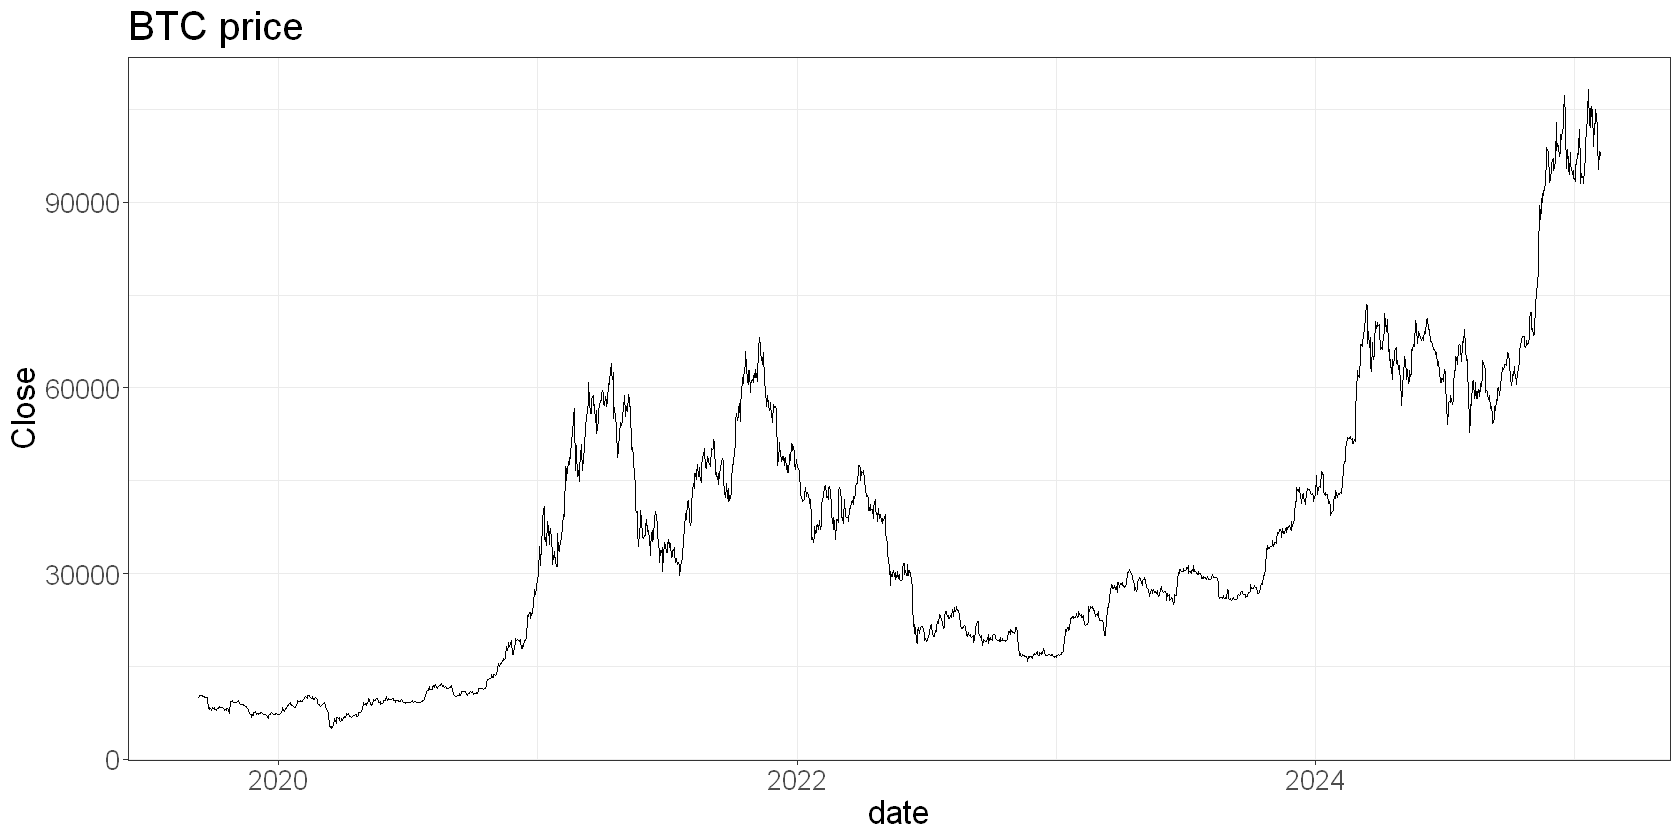

In [7]:
# plot prices
btc %>% 
  ggplot(aes(x = date, y = Close)) + geom_line() + ggtitle("BTC price")

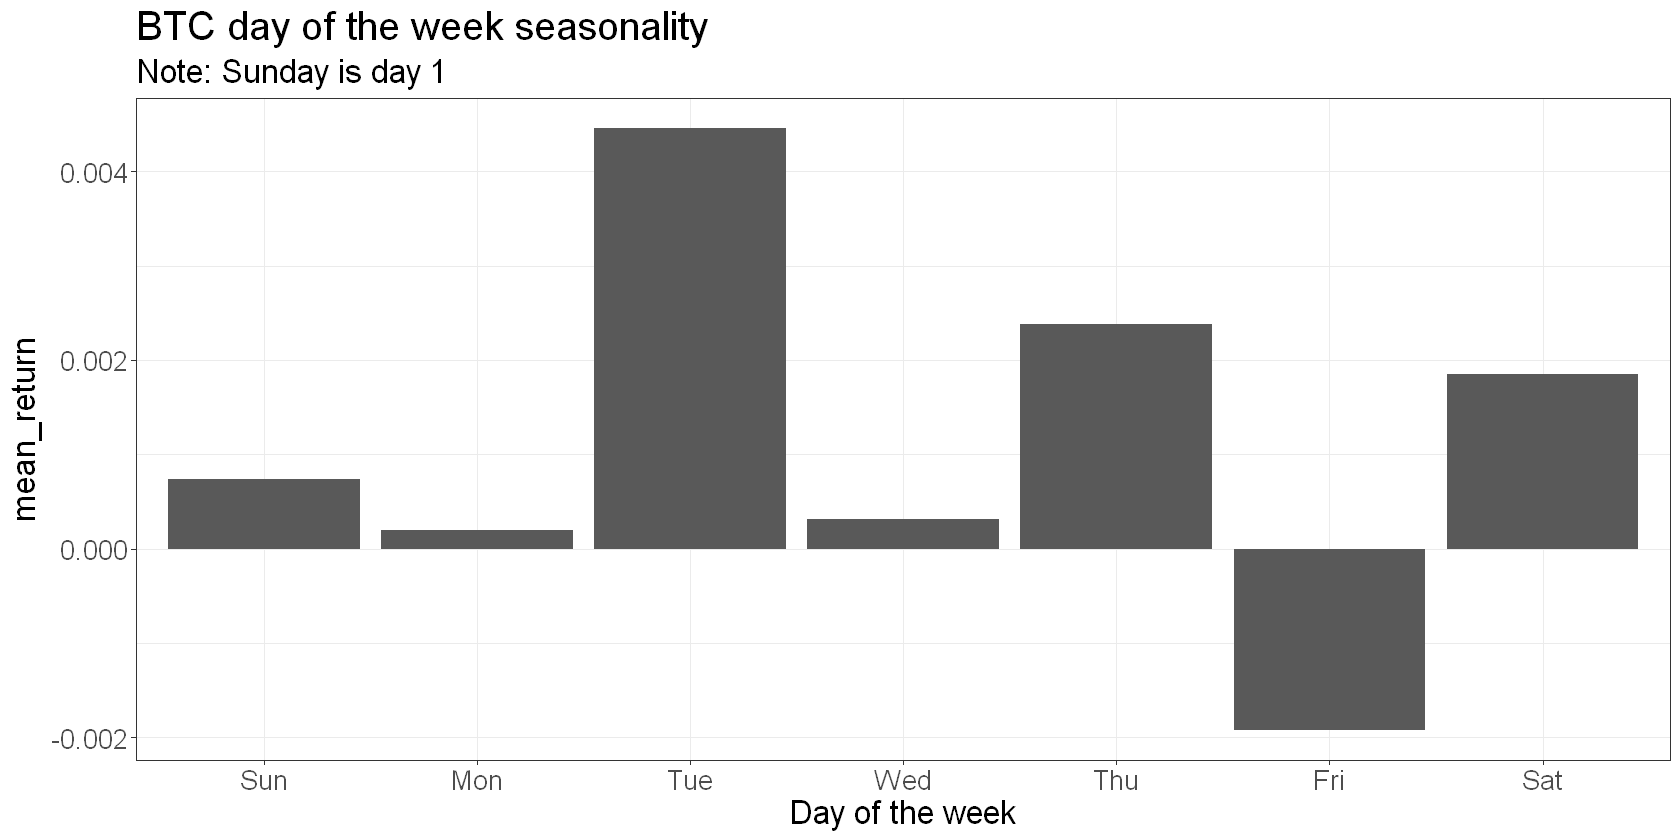

In [17]:
# seasonality within the actual data
actual <- btc %>% 
  group_by(dow) %>% 
  summarise(mean_return = mean(log_return))

actual %>% 
  ggplot(aes(x = dow, y = mean_return)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "BTC day of the week seasonality",
    subtitle = "Note: Sunday is day 1",
    x = "Day of the week"
  )

In [22]:
# randomise data

# set a random seed so that we can replicate our results
set.seed(503)

# make a vector of log_returns for sampling from
log_returns <- btc %>% pull(log_return)

# shuffle returns n times

# replicate(n, expr, simplify = "array")
n <- 10000
shuffled_returns <- replicate(n, sample(log_returns, replace = FALSE))
colnames(shuffled_returns) <- as.character(1:n)

# print dimensions of our shuffled data - should have ~5000 rows and n columns
print(dim(shuffled_returns))

# show a few rows of the first few columns
shuffled_returns[1:8, 1:8]

[1]  1976 10000


1,2,3,4,5,6,7,8
-0.013188852,0.006773547,-0.001279188,0.012305932,0.104416248,-0.02452570,0.017921522,-0.0002473126
-0.035878538,-0.002501406,-0.085161578,-0.033513907,0.002073345,-0.00592268,-0.018492925,0.0157440030
-0.001647518,0.017940112,0.032785561,-0.036807225,0.002197926,0.02753803,-0.006317971,0.0020766585
0.023308866,-0.034073241,0.044463442,-0.002501406,-0.002309739,-0.02478223,-0.021543111,-0.0032618503
-0.020591047,-0.012364985,0.004061873,0.025448402,0.001785057,-0.01009072,0.001044578,0.0379236106
-0.006850317,-0.017090585,-0.002702988,-0.003250093,0.014208444,0.01016963,-0.007822186,-0.0424397605
0.002979361,-0.016996990,-0.041852846,0.017304370,0.010708401,-0.01210895,-0.020932852,-0.0003142578
0.019974409,-0.035455624,0.018939036,0.031342031,-0.057093689,-0.04512035,0.028835275,-0.0046740144


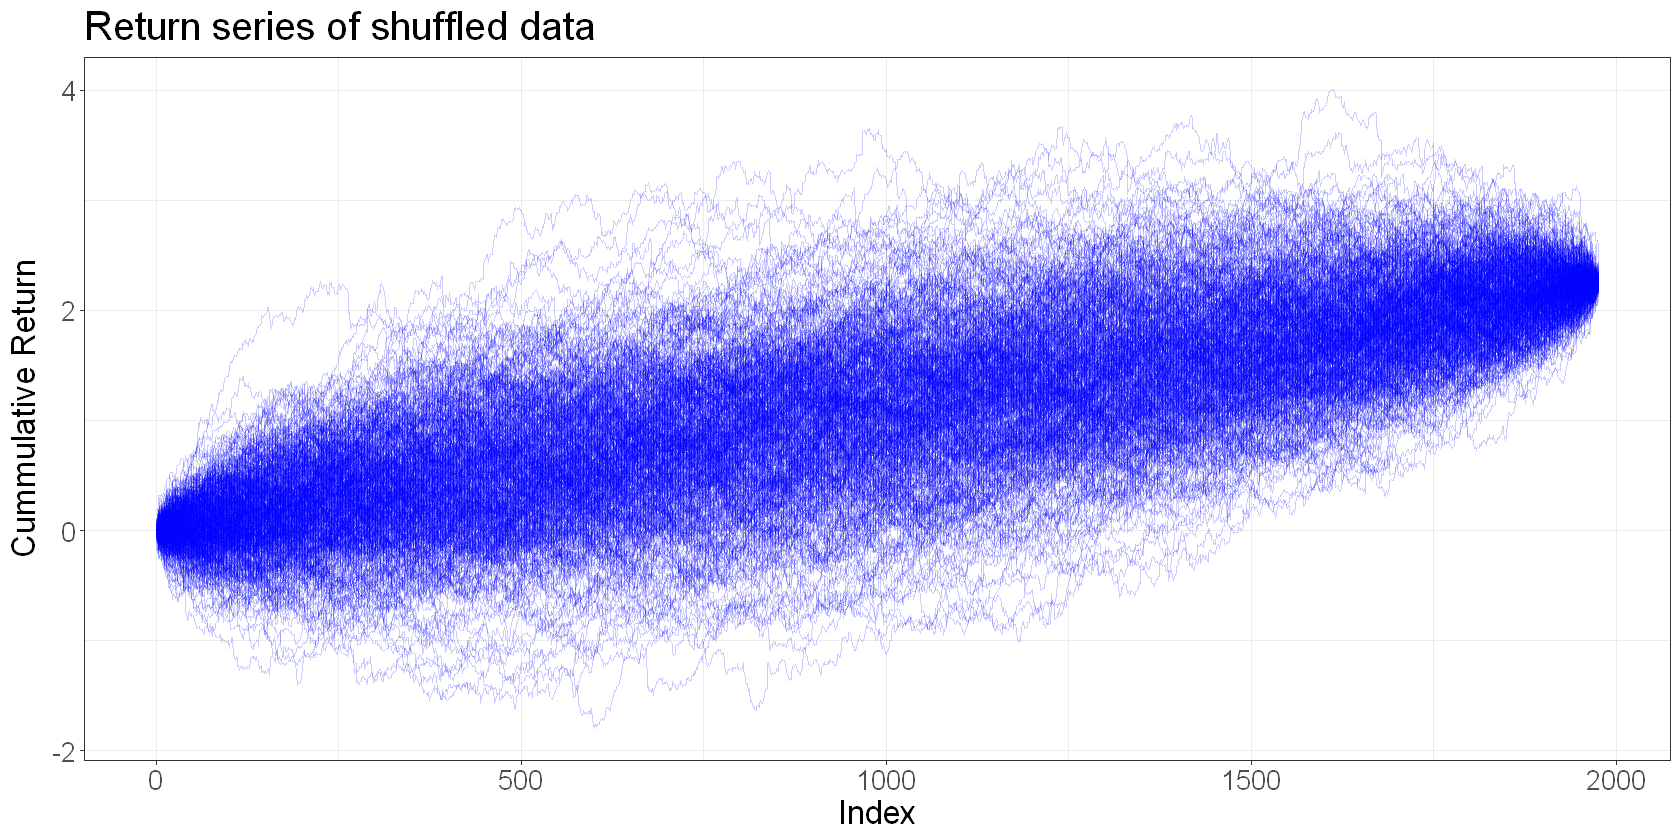

In [23]:
# plot 500 shuffled series to get a sense of how they behave
shuffled_returns[, 1:500] %>%
  apply(2, FUN = cumsum) %>%
  as_tibble() %>%
  mutate(index = row_number()) %>%
  pivot_longer(cols = -index, names_to = "series", values_to = "price") %>%
  ggplot(aes(x = index, y = price)) +
    geom_line(aes(group = series), colour = "blue", alpha = 0.2) +
    labs(
      x = "Index",
      y = "Cummulative Return",
      title = "Return series of shuffled data"
    )

Side note: Interesting thing here is that you don't see much evidence of the trendiness that we observe in the actual BTC prices series. Without doing any actual analysis, that's suggestive that the trendiness we do observe is unlikely due to randomness. 

In [24]:
shuffled_returns <- as_tibble(shuffled_returns) %>%
  # bind date from actual data 
  bind_cols(btc %>% select(date)) %>% 
  # get dow column again - this completes our shuffling operation
  mutate(dow = wday(date, label = TRUE))


# look at the first few price series
shuffled_returns %>%
  select(date, dow, 1:10) %>%
  head()

date,dow,1,2,3,4,5,6,7,8,9,10
<date>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-09-11,Wed,-0.013188852,0.006773547,-0.001279188,0.012305932,0.104416248,-0.02452570,0.017921522,-0.0002473126,0.027514426,0.011997215
2019-09-12,Thu,-0.035878538,-0.002501406,-0.085161578,-0.033513907,0.002073345,-0.00592268,-0.018492925,0.0157440030,0.013408055,0.028417812
2019-09-13,Fri,-0.001647518,0.017940112,0.032785561,-0.036807225,0.002197926,0.02753803,-0.006317971,0.0020766585,-0.002043919,-0.008948786
2019-09-14,Sat,0.023308866,-0.034073241,0.044463442,-0.002501406,-0.002309739,-0.02478223,-0.021543111,-0.0032618503,0.001044578,0.001325637
2019-09-15,Sun,-0.020591047,-0.012364985,0.004061873,0.025448402,0.001785057,-0.01009072,0.001044578,0.0379236106,-0.001143826,0.002183492
2019-09-16,Mon,-0.006850317,-0.017090585,-0.002702988,-0.003250093,0.014208444,0.01016963,-0.007822186,-0.0424397605,0.009484934,0.007220036


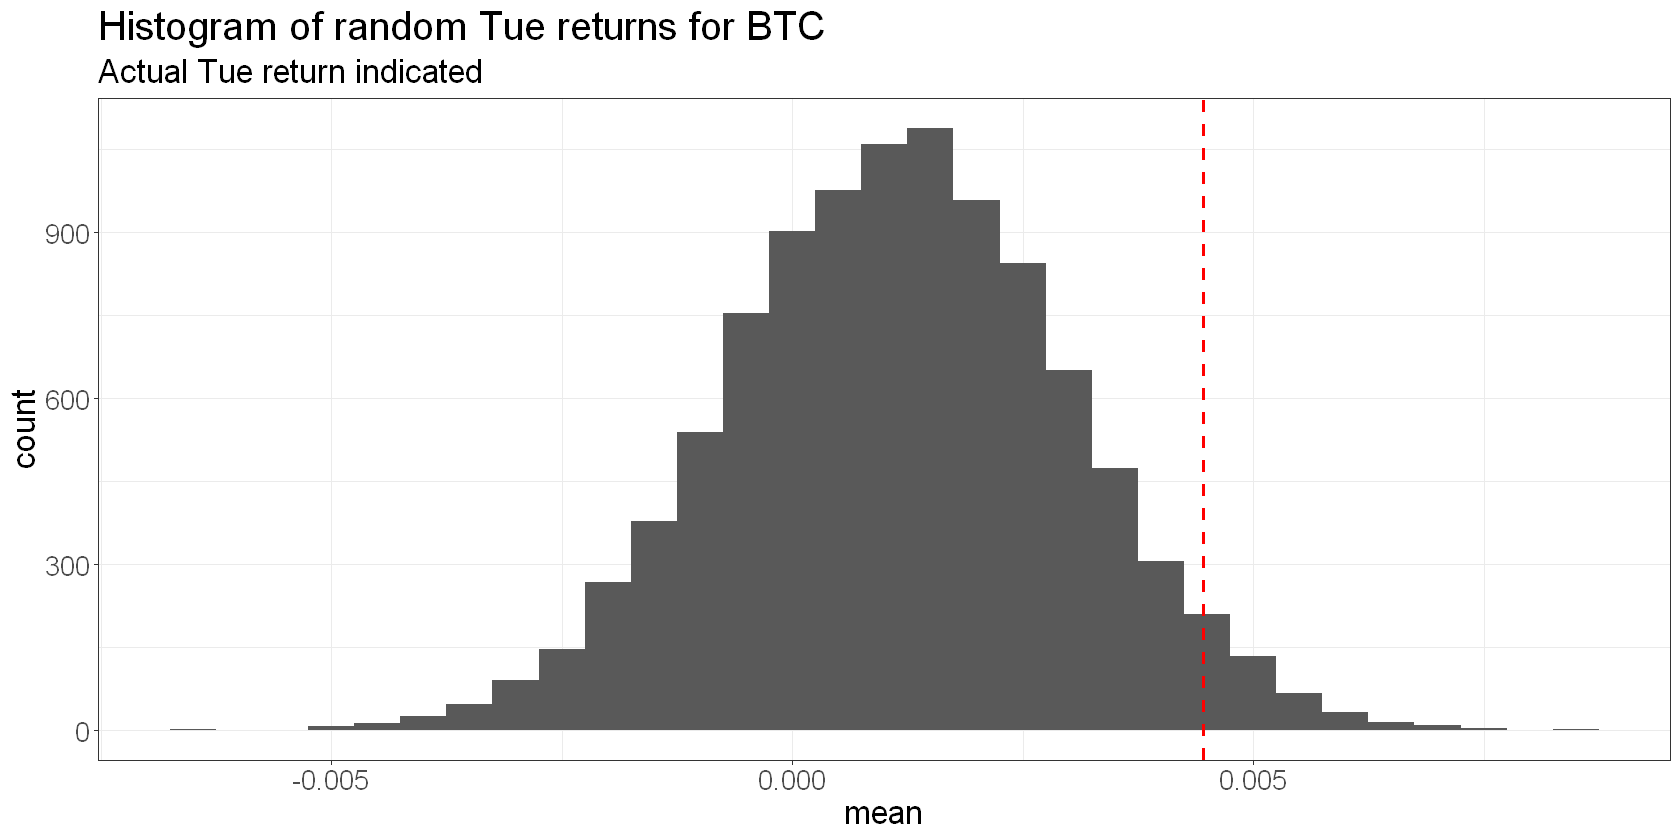

In [40]:
# Tuesday was the outlying day in our actual data - let's look at the spread of Tuesday's returns in our suffled data
# indicate acutal Tuesday mean return
shuffled_mean_tue_returns <- shuffled_returns %>% 
  dplyr::filter(dow == "Tue") %>% 
  summarise_all(~ if(is.numeric(.)) mean(.) else NA) %>% 
  pivot_longer(cols = c(-date, -dow), names_to = "series", values_to = "mean") 

actual_tue <- actual %>% 
  dplyr::filter(dow == "Tue") %>% 
  select(mean_return) %>%
  pull()
  
shuffled_mean_tue_returns %>% 
  ggplot(aes(x = mean)) +
  geom_histogram(binwidth = 0.0005) +
  geom_vline(
    xintercept = actual_tue, 
    linetype = "dashed", 
    color = "red",
    size = 1
  ) +
  labs(
    title = "Histogram of random Tue returns for BTC",
    subtitle = "Actual Tue return indicated"
  )  

In [41]:
# ECDF
ecdf_function <- ecdf(shuffled_mean_tue_returns$mean)

# p-value
p_value <- 1 - ecdf_function(actual_tue)

print(p_value)

[1] 0.0373
